Leer Texto de imagenes

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import csv
import matplotlib.pyplot as plt
import cv2
import os
import torch

Device: cuda


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

c:\Users\carlo\anaconda3\envs\SATURDAYS-2\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\carlo\.cache\huggingface\hub\models--microsoft--trocr-large-handwritten. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

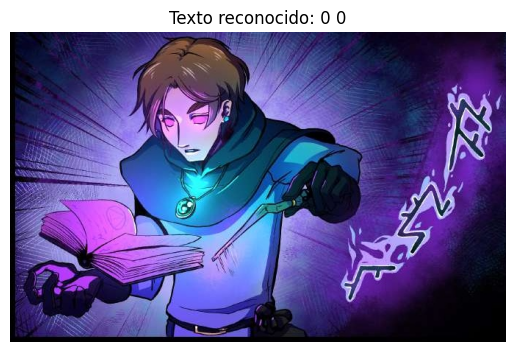

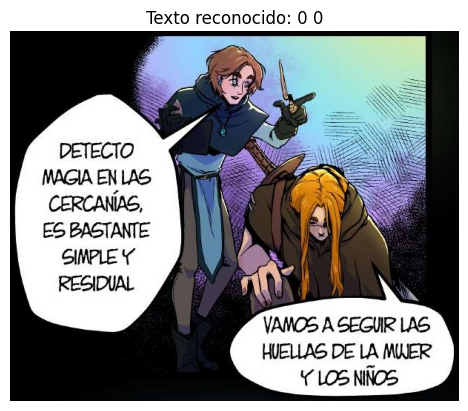

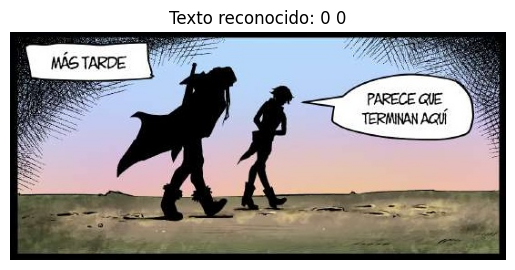

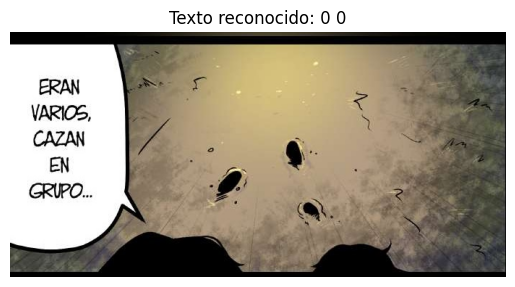

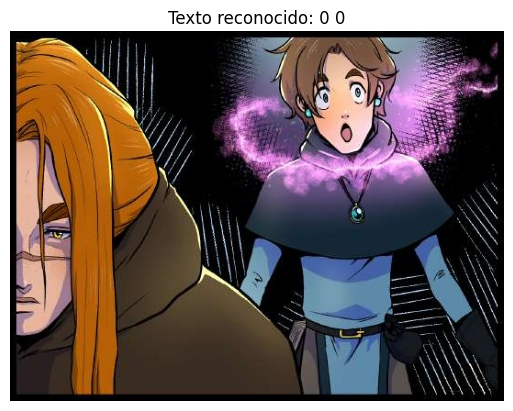

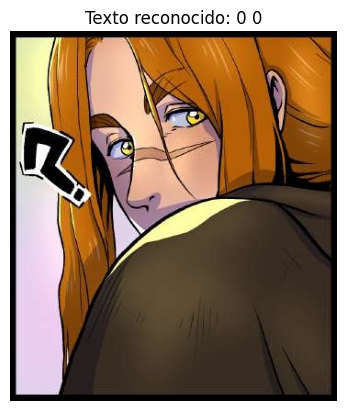

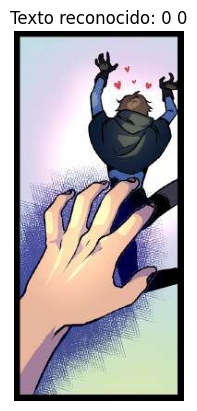

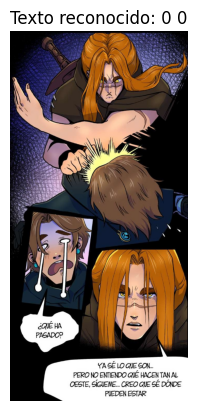

Texto reconocido de todas las imágenes guardado en data/output/output_text/output_text_trOCR.csv


In [9]:
# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Obtener la lista de archivos en la carpeta
folder_path = 'data\\output\\divide_images'
image_files = os.listdir(folder_path)

# Cargar el procesador y el modelo
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

# Iterar sobre cada imagen en la carpeta
for image_file in image_files:
    if image_file.endswith('.png') or image_file.endswith('.jpg') or image_file.endswith('.jpeg'):
        # Cargar la imagen
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Preprocesamiento de la imagen
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # Convertir la imagen en escala de grises a una imagen con 3 canales
        binary_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        
        # Convertir la imagen a tensor flotante de PyTorch y escalar los valores de píxeles
        image_tensor = torch.tensor(binary_image_rgb / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        # Procesar la imagen y generar el texto
        pixel_values = processor(images=image_tensor, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Mostrar la imagen
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Texto reconocido: ' + generated_text)
        plt.axis('off')
        plt.show()

        # Escribir el texto reconocido en un archivo CSV
        output_csv = 'data/output/output_text/output_text_trOCR.csv'
        with open(output_csv, 'a', newline='', encoding='utf-8') as csvfile:  # Use 'a' for append mode
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow([image_file, generated_text])


print("Texto reconocido de todas las imágenes guardado en", output_csv)